<a href="https://colab.research.google.com/github/dougyd92/ML-Foudations/blob/main/Notebooks/5_Regularization_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regularization for Linear Regression

In this notebook, we'll explore **regularization techniques** that help prevent overfitting in linear regression models. We'll use the California Housing dataset and demonstrate how regularization becomes essential when we create many polynomial features.

## Setup and Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## Load and Explore the California Housing Dataset

In [ ]:
# Load the dataset
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = california.target

print("Dataset shape:", X.shape)
print("\nFeatures:")
for i, name in enumerate(california.feature_names):
    print(f"  {i+1}. {name}")
print(f"\nTarget: Median house value (in $100,000s)")

Dataset shape: (20640, 8)

Features:
  1. MedInc
  2. HouseAge
  3. AveRooms
  4. AveBedrms
  5. Population
  6. AveOccup
  7. Latitude
  8. Longitude

Target: Median house value (in $100,000s)


In [ ]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
X.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


In [ ]:
# Use a subset for faster computation in this tutorial
# In practice, you'd use the full dataset
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=5000, random_state=42)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")

Training set: 4000 samples
Test set: 1000 samples
Number of features: 8


---
# Section 1: The Overfitting Problem

## The Problem with Complex Models

Complex models can fit training data perfectly but fail on new data. This is called **overfitting**—when the model learns noise instead of true patterns.

**Key points:**
- High-degree polynomials and many features increase overfitting risk
- There's always a trade-off between model complexity and generalization
- More features doesn't always mean better predictions!

Let's demonstrate this by creating polynomial features from our 8 original features.

In [ ]:
# Create polynomial features of different degrees
# This demonstrates how feature count explodes with polynomial degree

for degree in [1, 2, 3]:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X_train)
    print(f"Degree {degree}: {X_train.shape[1]} original features → {X_poly.shape[1]} polynomial features")

Degree 1: 8 original features → 8 polynomial features
Degree 2: 8 original features → 44 polynomial features
Degree 3: 8 original features → 164 polynomial features


With just 8 features, degree 2 gives us 44 features, and degree 3 gives us 164! This explosion of features creates serious overfitting risk.

In [ ]:
# Demonstrate overfitting with polynomial features
# Compare training vs test performance as model complexity increases

degrees = [1, 2, 3]
train_scores = []
test_scores = []
n_features_list = []

for degree in degrees:
    # Create pipeline: polynomial features → scaling → linear regression
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ])

    # Fit and evaluate
    pipeline.fit(X_train, y_train)

    train_r2 = pipeline.score(X_train, y_train)
    test_r2 = pipeline.score(X_test, y_test)

    # Get number of features
    n_features = pipeline.named_steps['poly'].n_output_features_

    train_scores.append(train_r2)
    test_scores.append(test_r2)
    n_features_list.append(n_features)

    print(f"Degree {degree} ({n_features:3d} features): Train R² = {train_r2:.4f}, Test R² = {test_r2:.4f}, Gap = {train_r2 - test_r2:.4f}")

Degree 1 (  8 features): Train R² = 0.5977, Test R² = 0.5801, Gap = 0.0176
Degree 2 ( 44 features): Train R² = 0.6961, Test R² = 0.6061, Gap = 0.0900
Degree 3 (164 features): Train R² = 0.7534, Test R² = -1285.4621, Gap = 1286.2155


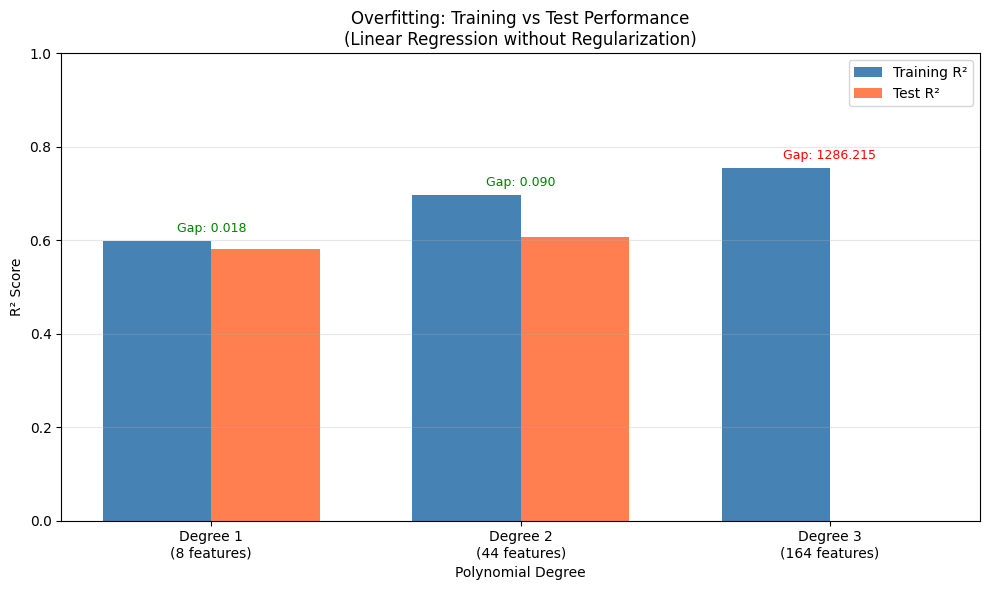

In [ ]:
# Visualize the overfitting problem
fig, ax = plt.subplots(figsize=(10, 6))

x_positions = np.arange(len(degrees))
width = 0.35

bars1 = ax.bar(x_positions - width/2, train_scores, width, label='Training R²', color='steelblue')
bars2 = ax.bar(x_positions + width/2, test_scores, width, label='Test R²', color='coral')

ax.set_xlabel('Polynomial Degree')
ax.set_ylabel('R² Score')
ax.set_title('Overfitting: Training vs Test Performance\n(Linear Regression without Regularization)')
ax.set_xticks(x_positions)
ax.set_xticklabels([f'Degree {d}\n({n} features)' for d, n in zip(degrees, n_features_list)])
ax.legend()
ax.set_ylim(0, 1.0)
ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax.grid(axis='y', alpha=0.3)

# Add gap annotations
for i, (train, test) in enumerate(zip(train_scores, test_scores)):
    gap = train - test
    ax.annotate(f'Gap: {gap:.3f}', xy=(i, max(train, test) + 0.02),
                ha='center', fontsize=9, color='red' if gap > 0.1 else 'green')

plt.tight_layout()
plt.show()

**Key Observation:** As we add more polynomial features, the gap between training and test performance grows. This is the classic sign of overfitting!

---
# Section 2: Bias-Variance Tradeoff

## Understanding Bias and Variance

The **bias-variance tradeoff** is fundamental to understanding model performance:

- **Bias**: Error from overly simple models that can't capture the true relationship (underfitting)
- **Variance**: Error from models that are too sensitive to the training data (overfitting)

**Goal:** Find the sweet spot that minimizes total error. Regularization helps us control this tradeoff.

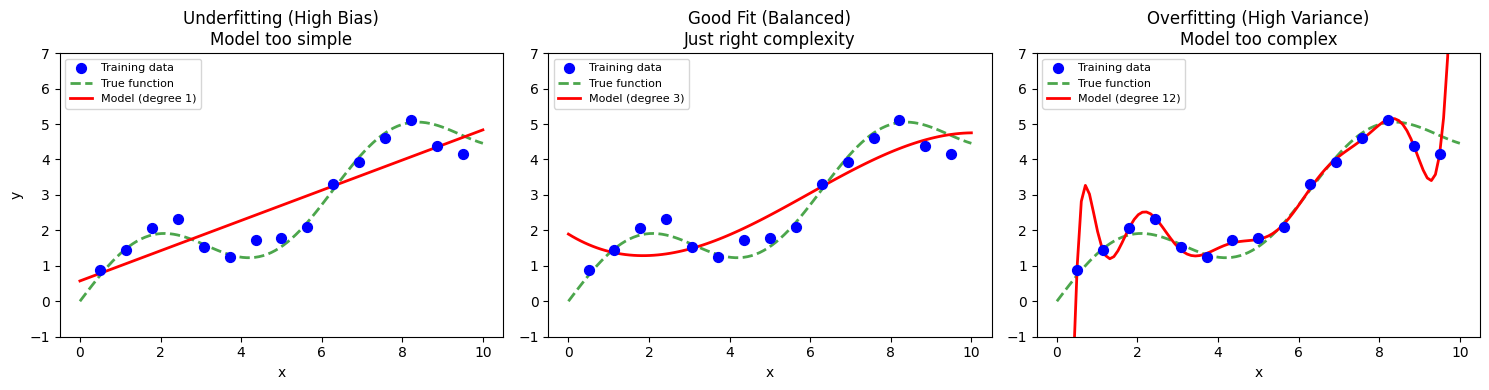

In [ ]:
# Visualize bias-variance tradeoff conceptually
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Generate synthetic data for visualization
np.random.seed(42)
x_demo = np.linspace(0, 10, 100)
y_true = np.sin(x_demo) + 0.5 * x_demo  # True underlying function
x_points = np.linspace(0.5, 9.5, 15)
y_points = np.sin(x_points) + 0.5 * x_points + np.random.normal(0, 0.3, len(x_points))

# Underfitting (high bias)
axes[0].scatter(x_points, y_points, color='blue', s=50, zorder=5, label='Training data')
axes[0].plot(x_demo, y_true, 'g--', linewidth=2, label='True function', alpha=0.7)
# Fit a simple line (underfitting)
z = np.polyfit(x_points, y_points, 1)
axes[0].plot(x_demo, np.polyval(z, x_demo), 'r-', linewidth=2, label='Model (degree 1)')
axes[0].set_title('Underfitting (High Bias)\nModel too simple', fontsize=12)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].legend(loc='upper left', fontsize=8)
axes[0].set_ylim(-1, 7)

# Good fit (balanced)
axes[1].scatter(x_points, y_points, color='blue', s=50, zorder=5, label='Training data')
axes[1].plot(x_demo, y_true, 'g--', linewidth=2, label='True function', alpha=0.7)
# Fit a reasonable polynomial
z = np.polyfit(x_points, y_points, 3)
axes[1].plot(x_demo, np.polyval(z, x_demo), 'r-', linewidth=2, label='Model (degree 3)')
axes[1].set_title('Good Fit (Balanced)\nJust right complexity', fontsize=12)
axes[1].set_xlabel('x')
axes[1].legend(loc='upper left', fontsize=8)
axes[1].set_ylim(-1, 7)

# Overfitting (high variance)
axes[2].scatter(x_points, y_points, color='blue', s=50, zorder=5, label='Training data')
axes[2].plot(x_demo, y_true, 'g--', linewidth=2, label='True function', alpha=0.7)
# Fit a high-degree polynomial (overfitting)
z = np.polyfit(x_points, y_points, 12)
y_overfit = np.polyval(z, x_demo)
y_overfit = np.clip(y_overfit, -2, 10)  # Clip for visualization
axes[2].plot(x_demo, y_overfit, 'r-', linewidth=2, label='Model (degree 12)')
axes[2].set_title('Overfitting (High Variance)\nModel too complex', fontsize=12)
axes[2].set_xlabel('x')
axes[2].legend(loc='upper left', fontsize=8)
axes[2].set_ylim(-1, 7)

plt.tight_layout()
plt.show()

---
# Section 3: Regularization - Penalizing Complexity

## The Regularization Idea

Regularization adds a **penalty term** to the loss function that discourages large coefficient values, leading to simpler, more generalizable models.

### Ordinary Least Squares (No Regularization)

Standard linear regression minimizes the sum of squared errors:

$$\hat{\beta}_{OLS} = \arg\min_{\beta} \sum_{i=1}^{n} (y_i - X_i\beta)^2 = \arg\min_{\beta} \|y - X\beta\|_2^2$$

### Regularized Regression

We add a penalty term that penalizes large coefficients:

$$\hat{\beta}_{reg} = \arg\min_{\beta} \left[ \|y - X\beta\|_2^2 + \lambda \cdot R(\beta) \right]$$

Where:
- $\lambda$ (lambda) controls the strength of regularization
- $R(\beta)$ is the regularization function (different for Ridge, Lasso, Elastic Net)

---
# Section 4: Ridge Regression (L2 Regularization)

## Ridge: Shrinking Coefficients

Ridge regression uses the **L2 penalty** (squared coefficients):

$$\hat{\beta}_{Ridge} = \arg\min_{\beta} \left[ \|y - X\beta\|_2^2 + \lambda \sum_{j=1}^{p} \beta_j^2 \right]$$

**Key characteristics:**
- Penalizes large coefficients proportionally to their **square**
- Shrinks coefficients toward zero but **never exactly to zero**
- Handles multicollinearity well (keeps all features)
- More stable when features are correlated

In [ ]:
# Create polynomial features (degree 2) for our demonstrations
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

print(f"Polynomial features created: {X_train_poly.shape[1]} features")

# Scale features - CRITICAL for regularization!
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

Polynomial features created: 44 features


In [ ]:
# Compare different alpha (lambda) values for Ridge
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

print("Ridge Regression: Effect of Alpha (λ)")
print("=" * 60)

ridge_results = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)

    train_r2 = ridge.score(X_train_scaled, y_train)
    test_r2 = ridge.score(X_test_scaled, y_test)

    # Count "near-zero" coefficients (for comparison with Lasso later)
    n_small_coefs = np.sum(np.abs(ridge.coef_) < 0.01)

    ridge_results.append({
        'alpha': alpha,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'n_small_coefs': n_small_coefs,
        'coef_norm': np.linalg.norm(ridge.coef_)
    })

    print(f"α = {alpha:7.3f}: Train R² = {train_r2:.4f}, Test R² = {test_r2:.4f}, ||coef|| = {np.linalg.norm(ridge.coef_):.2f}")

Ridge Regression: Effect of Alpha (λ)
α =   0.001: Train R² = 0.6959, Test R² = 0.6561, ||coef|| = 70.14
α =   0.010: Train R² = 0.6936, Test R² = 0.6474, ||coef|| = 40.88
α =   0.100: Train R² = 0.6858, Test R² = 0.6407, ||coef|| = 14.32
α =   1.000: Train R² = 0.6781, Test R² = 0.6325, ||coef|| = 5.14
α =  10.000: Train R² = 0.6671, Test R² = 0.2970, ||coef|| = 2.71
α = 100.000: Train R² = 0.6344, Test R² = -0.0301, ||coef|| = 1.20
α = 1000.000: Train R² = 0.5708, Test R² = 0.3377, ||coef|| = 0.53


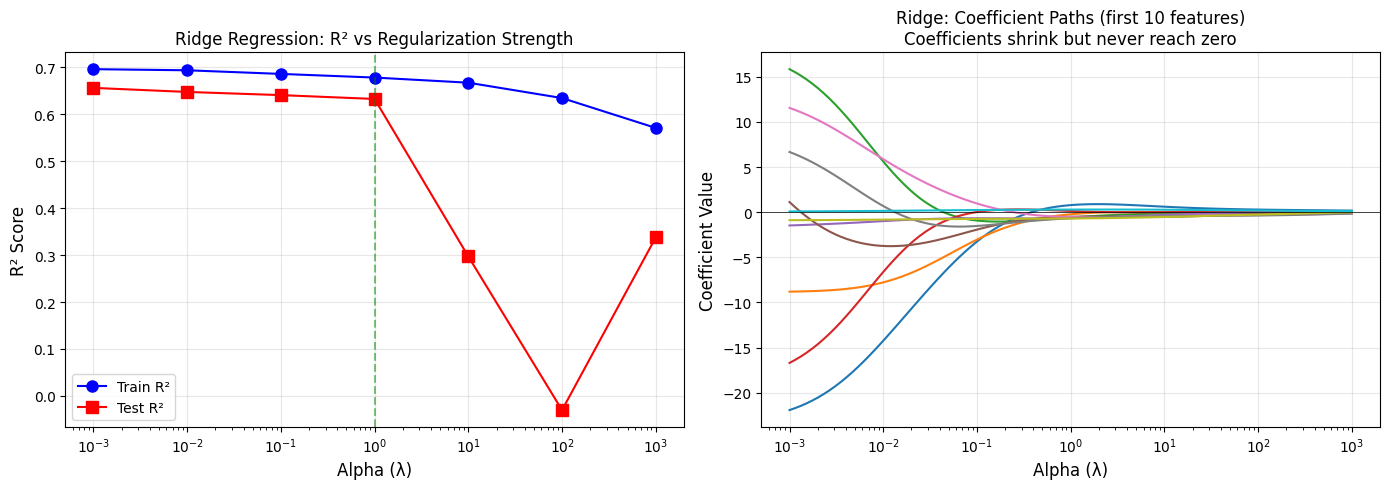

In [ ]:
# Visualize Ridge coefficient shrinkage
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: R² vs Alpha
ridge_df = pd.DataFrame(ridge_results)
axes[0].semilogx(ridge_df['alpha'], ridge_df['train_r2'], 'b-o', label='Train R²', markersize=8)
axes[0].semilogx(ridge_df['alpha'], ridge_df['test_r2'], 'r-s', label='Test R²', markersize=8)
axes[0].set_xlabel('Alpha (λ)', fontsize=12)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('Ridge Regression: R² vs Regularization Strength', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=1, color='green', linestyle='--', alpha=0.5, label='α=1')

# Plot 2: Coefficient paths
alphas_fine = np.logspace(-3, 3, 100)
coefs = []
for alpha in alphas_fine:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    coefs.append(ridge.coef_)
coefs = np.array(coefs)

# Plot first 10 coefficients for clarity
for i in range(10):
    axes[1].semilogx(alphas_fine, coefs[:, i], linewidth=1.5)

axes[1].set_xlabel('Alpha (λ)', fontsize=12)
axes[1].set_ylabel('Coefficient Value', fontsize=12)
axes[1].set_title('Ridge: Coefficient Paths (first 10 features)\nCoefficients shrink but never reach zero', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

**Key Observation:** Ridge coefficients shrink toward zero as α increases, but they **never become exactly zero**. All features are kept in the model.

---
# Section 5: Lasso Regression (L1 Regularization)

## Lasso: Least Absolute Shrinkage and Selection Operator

Lasso uses the **L1 penalty** (absolute value of coefficients):

$$\hat{\beta}_{Lasso} = \arg\min_{\beta} \left[ \|y - X\beta\|_2^2 + \lambda \sum_{j=1}^{p} |\beta_j| \right]$$

**Key characteristics:**
- Penalizes the **absolute value** of coefficients
- **Key difference from Ridge:** Can shrink coefficients **exactly to zero**
- Performs **automatic feature selection**
- Creates sparse models (many coefficients = 0)

In [ ]:
# Compare different alpha values for Lasso
alphas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]

print("Lasso Regression: Effect of Alpha (λ)")
print("=" * 70)

lasso_results = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)

    train_r2 = lasso.score(X_train_scaled, y_train)
    test_r2 = lasso.score(X_test_scaled, y_test)

    # Count exactly zero coefficients
    n_zero_coefs = np.sum(lasso.coef_ == 0)
    n_nonzero = np.sum(lasso.coef_ != 0)

    lasso_results.append({
        'alpha': alpha,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'n_zero_coefs': n_zero_coefs,
        'n_nonzero': n_nonzero
    })

    print(f"α = {alpha:6.4f}: Train R² = {train_r2:.4f}, Test R² = {test_r2:.4f}, Non-zero coefs: {n_nonzero:2d}/{X_train_scaled.shape[1]}")

Lasso Regression: Effect of Alpha (λ)
α = 0.0001: Train R² = 0.6811, Test R² = 0.6842, Non-zero coefs: 42/44
α = 0.0010: Train R² = 0.6714, Test R² = -0.0920, Non-zero coefs: 27/44
α = 0.0100: Train R² = 0.6140, Test R² = 0.4425, Non-zero coefs: 17/44
α = 0.1000: Train R² = 0.4897, Test R² = 0.5162, Non-zero coefs:  3/44
α = 0.5000: Train R² = 0.2827, Test R² = 0.2858, Non-zero coefs:  1/44
α = 1.0000: Train R² = 0.0000, Test R² = -0.0004, Non-zero coefs:  0/44


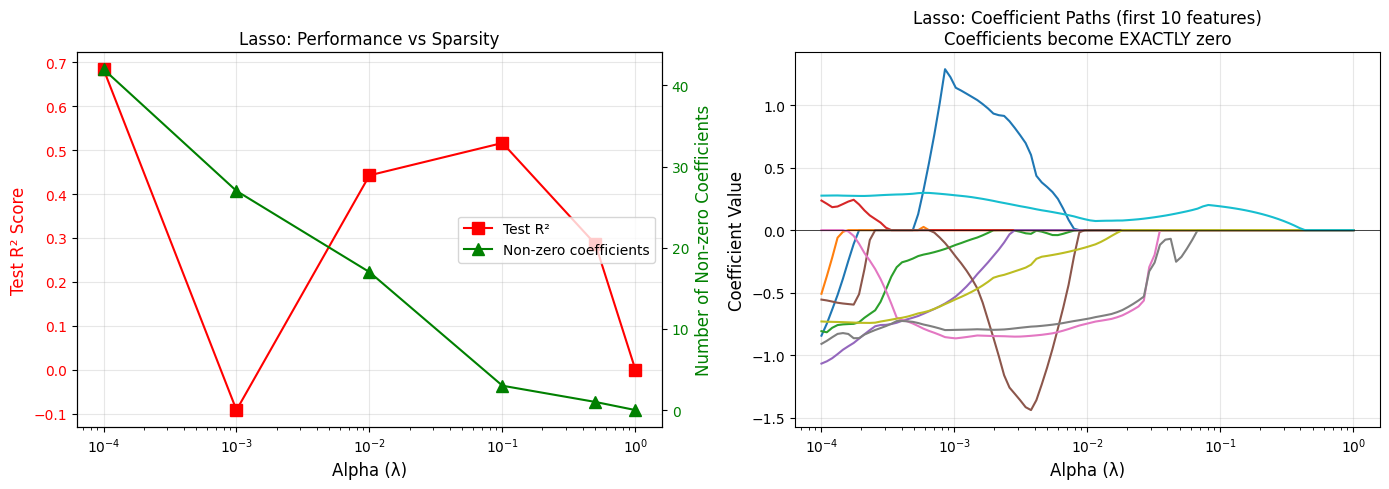

In [ ]:
# Visualize Lasso coefficient paths - showing sparsity
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: R² and feature count vs Alpha
lasso_df = pd.DataFrame(lasso_results)
ax1 = axes[0]
ax2 = ax1.twinx()

line1, = ax1.semilogx(lasso_df['alpha'], lasso_df['test_r2'], 'r-s', label='Test R²', markersize=8)
line2, = ax2.semilogx(lasso_df['alpha'], lasso_df['n_nonzero'], 'g-^', label='Non-zero coefficients', markersize=8)

ax1.set_xlabel('Alpha (λ)', fontsize=12)
ax1.set_ylabel('Test R² Score', color='red', fontsize=12)
ax2.set_ylabel('Number of Non-zero Coefficients', color='green', fontsize=12)
ax1.set_title('Lasso: Performance vs Sparsity', fontsize=12)
ax1.tick_params(axis='y', labelcolor='red')
ax2.tick_params(axis='y', labelcolor='green')

lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right')
ax1.grid(True, alpha=0.3)

# Plot 2: Coefficient paths for Lasso
alphas_fine = np.logspace(-4, 0, 100)
coefs = []
for alpha in alphas_fine:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    coefs.append(lasso.coef_)
coefs = np.array(coefs)

# Plot first 10 coefficients for clarity
for i in range(10):
    axes[1].semilogx(alphas_fine, coefs[:, i], linewidth=1.5)

axes[1].set_xlabel('Alpha (λ)', fontsize=12)
axes[1].set_ylabel('Coefficient Value', fontsize=12)
axes[1].set_title('Lasso: Coefficient Paths (first 10 features)\nCoefficients become EXACTLY zero', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

**Key Observation:** Unlike Ridge, Lasso coefficients **become exactly zero** as α increases. This is automatic feature selection!

---
# Section 6: Comparing L1 vs L2 Regularization

## Visual Comparison: Why L1 Creates Sparsity

The difference in behavior comes from the **geometry** of the penalty regions:

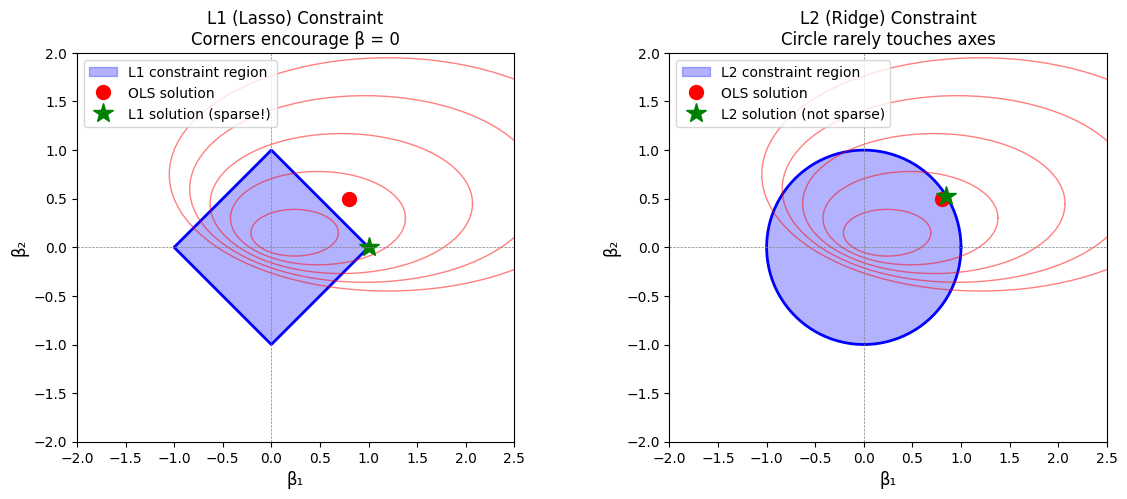

In [ ]:
# Visualize L1 vs L2 constraint regions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Create elliptical contours (representing RSS)
theta = np.linspace(0, 2*np.pi, 100)

# L1 constraint (diamond)
ax = axes[0]
# Diamond shape for L1
l1_x = np.array([1, 0, -1, 0, 1])
l1_y = np.array([0, 1, 0, -1, 0])
ax.fill(l1_x, l1_y, alpha=0.3, color='blue', label='L1 constraint region')
ax.plot(l1_x, l1_y, 'b-', linewidth=2)

# Elliptical contours
for scale in [0.3, 0.6, 0.9, 1.2, 1.5]:
    ellipse_x = scale * (1.5 * np.cos(theta) + 0.8)
    ellipse_y = scale * (0.8 * np.sin(theta) + 0.5)
    ax.plot(ellipse_x, ellipse_y, 'r-', alpha=0.5, linewidth=1)

ax.plot(0.8, 0.5, 'ro', markersize=10, label='OLS solution')
ax.plot(1, 0, 'g*', markersize=15, label='L1 solution (sparse!)')
ax.set_xlim(-2, 2.5)
ax.set_ylim(-2, 2)
ax.set_xlabel('β₁', fontsize=12)
ax.set_ylabel('β₂', fontsize=12)
ax.set_title('L1 (Lasso) Constraint\nCorners encourage β = 0', fontsize=12)
ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)
ax.legend(loc='upper left')
ax.set_aspect('equal')

# L2 constraint (circle)
ax = axes[1]
# Circle for L2
circle_x = np.cos(theta)
circle_y = np.sin(theta)
ax.fill(circle_x, circle_y, alpha=0.3, color='blue', label='L2 constraint region')
ax.plot(circle_x, circle_y, 'b-', linewidth=2)

# Elliptical contours
for scale in [0.3, 0.6, 0.9, 1.2, 1.5]:
    ellipse_x = scale * (1.5 * np.cos(theta) + 0.8)
    ellipse_y = scale * (0.8 * np.sin(theta) + 0.5)
    ax.plot(ellipse_x, ellipse_y, 'r-', alpha=0.5, linewidth=1)

ax.plot(0.8, 0.5, 'ro', markersize=10, label='OLS solution')
ax.plot(0.85, 0.53, 'g*', markersize=15, label='L2 solution (not sparse)')
ax.set_xlim(-2, 2.5)
ax.set_ylim(-2, 2)
ax.set_xlabel('β₁', fontsize=12)
ax.set_ylabel('β₂', fontsize=12)
ax.set_title('L2 (Ridge) Constraint\nCircle rarely touches axes', fontsize=12)
ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)
ax.legend(loc='upper left')
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

**Geometric Intuition:**
- The **red ellipses** show contours of equal RSS (residual sum of squares)
- The **blue region** is the constraint region (where coefficients must lie)
- The solution is where the smallest ellipse touches the constraint region
- **L1 (diamond)**: Corners are on the axes → coefficients often become exactly 0
- **L2 (circle)**: Smooth surface rarely touches axes → coefficients shrink but don't become 0

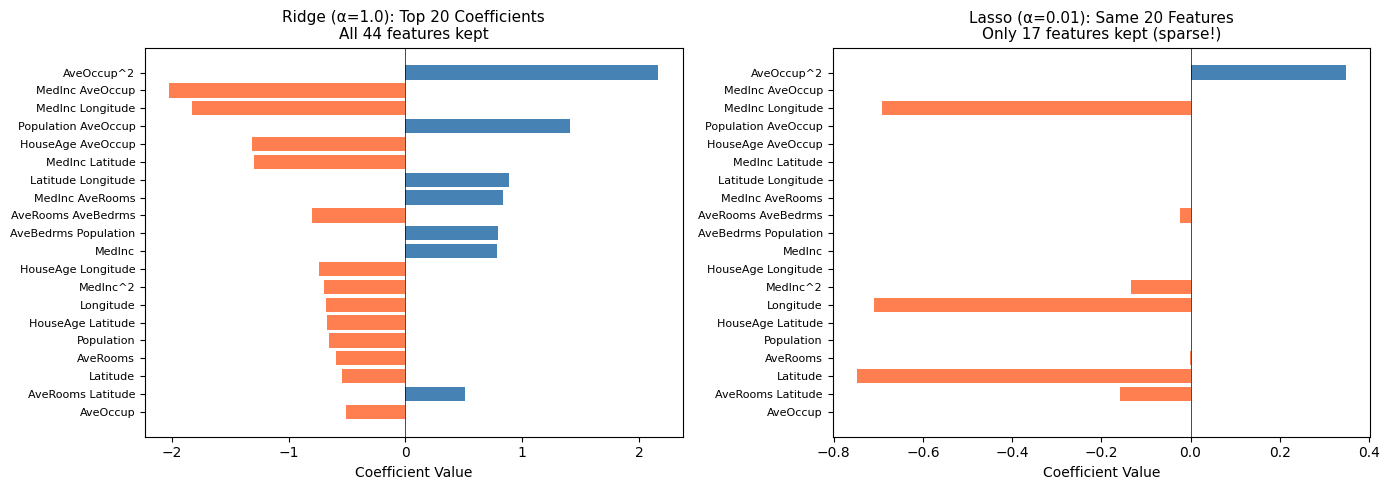


Ridge: 44 non-zero coefficients
Lasso: 17 non-zero coefficients


In [ ]:
# Direct comparison: Ridge vs Lasso coefficients
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Fit both models with comparable regularization
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=0.01, max_iter=10000)

ridge.fit(X_train_scaled, y_train)
lasso.fit(X_train_scaled, y_train)

# Get feature names for polynomial features
feature_names = poly.get_feature_names_out(X.columns)

# Sort by absolute Ridge coefficient value for visualization
sorted_idx = np.argsort(np.abs(ridge.coef_))[::-1][:20]  # Top 20

# Ridge coefficients
ax = axes[0]
colors = ['steelblue' if c >= 0 else 'coral' for c in ridge.coef_[sorted_idx]]
ax.barh(range(len(sorted_idx)), ridge.coef_[sorted_idx], color=colors)
ax.set_yticks(range(len(sorted_idx)))
ax.set_yticklabels([feature_names[i][:20] for i in sorted_idx], fontsize=8)
ax.set_xlabel('Coefficient Value')
ax.set_title(f'Ridge (α=1.0): Top 20 Coefficients\nAll {len(ridge.coef_)} features kept', fontsize=11)
ax.axvline(x=0, color='black', linewidth=0.5)
ax.invert_yaxis()

# Lasso coefficients (same features for comparison)
ax = axes[1]
colors = ['steelblue' if c >= 0 else 'coral' for c in lasso.coef_[sorted_idx]]
ax.barh(range(len(sorted_idx)), lasso.coef_[sorted_idx], color=colors)
ax.set_yticks(range(len(sorted_idx)))
ax.set_yticklabels([feature_names[i][:20] for i in sorted_idx], fontsize=8)
ax.set_xlabel('Coefficient Value')
n_nonzero = np.sum(lasso.coef_ != 0)
ax.set_title(f'Lasso (α=0.01): Same 20 Features\nOnly {n_nonzero} features kept (sparse!)', fontsize=11)
ax.axvline(x=0, color='black', linewidth=0.5)
ax.invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\nRidge: {np.sum(ridge.coef_ != 0)} non-zero coefficients")
print(f"Lasso: {np.sum(lasso.coef_ != 0)} non-zero coefficients")

---
# Section 7: Elastic Net (L1 + L2 Regularization)

## Elastic Net: Best of Both Worlds

Elastic Net combines Ridge and Lasso penalties:

$$\hat{\beta}_{ElasticNet} = \arg\min_{\beta} \left[ \|y - X\beta\|_2^2 + \lambda_1 \sum_{j=1}^{p} |\beta_j| + \lambda_2 \sum_{j=1}^{p} \beta_j^2 \right]$$

In scikit-learn, this is parameterized as:
- `alpha`: Overall regularization strength
- `l1_ratio`: Mix between L1 and L2 (0 = Ridge, 1 = Lasso)

**When to use Elastic Net:**
- You want sparsity (like Lasso) but with more stability (like Ridge)
- You have groups of correlated features
- Lasso might be too aggressive in feature selection

In [ ]:
# Compare different l1_ratio values
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
alpha = 0.01

print("Elastic Net: Effect of L1 Ratio (with α = 0.01)")
print("=" * 70)
print("l1_ratio = 0 → Pure Ridge | l1_ratio = 1 → Pure Lasso")
print("-" * 70)

enet_results = []
for l1_ratio in l1_ratios:
    enet = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)
    enet.fit(X_train_scaled, y_train)

    train_r2 = enet.score(X_train_scaled, y_train)
    test_r2 = enet.score(X_test_scaled, y_test)
    n_nonzero = np.sum(enet.coef_ != 0)

    enet_results.append({
        'l1_ratio': l1_ratio,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'n_nonzero': n_nonzero
    })

    print(f"l1_ratio = {l1_ratio:.1f}: Train R² = {train_r2:.4f}, Test R² = {test_r2:.4f}, Non-zero coefs: {n_nonzero:2d}/{X_train_scaled.shape[1]}")

Elastic Net: Effect of L1 Ratio (with α = 0.01)
l1_ratio = 0 → Pure Ridge | l1_ratio = 1 → Pure Lasso
----------------------------------------------------------------------
l1_ratio = 0.1: Train R² = 0.6479, Test R² = -0.2635, Non-zero coefs: 41/44
l1_ratio = 0.3: Train R² = 0.6405, Test R² = -0.3097, Non-zero coefs: 34/44
l1_ratio = 0.5: Train R² = 0.6339, Test R² = -0.0660, Non-zero coefs: 26/44
l1_ratio = 0.7: Train R² = 0.6273, Test R² = 0.1622, Non-zero coefs: 24/44
l1_ratio = 0.9: Train R² = 0.6194, Test R² = 0.3379, Non-zero coefs: 21/44


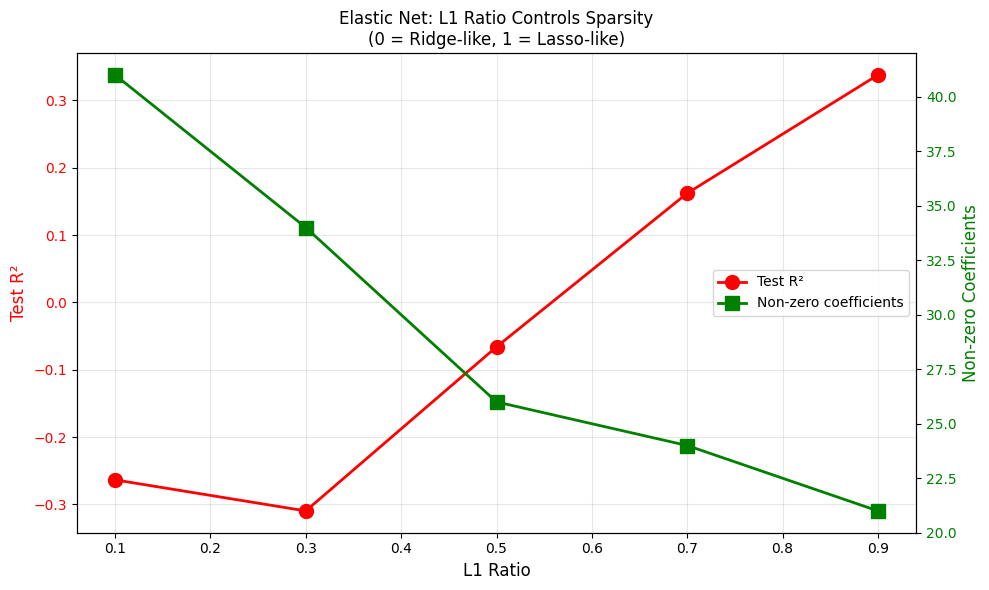

In [ ]:
# Visualize Elastic Net behavior across l1_ratio spectrum
fig, ax = plt.subplots(figsize=(10, 6))

enet_df = pd.DataFrame(enet_results)

ax2 = ax.twinx()

line1, = ax.plot(enet_df['l1_ratio'], enet_df['test_r2'], 'r-o', markersize=10, linewidth=2, label='Test R²')
line2, = ax2.plot(enet_df['l1_ratio'], enet_df['n_nonzero'], 'g-s', markersize=10, linewidth=2, label='Non-zero coefficients')

ax.set_xlabel('L1 Ratio', fontsize=12)
ax.set_ylabel('Test R²', color='red', fontsize=12)
ax2.set_ylabel('Non-zero Coefficients', color='green', fontsize=12)
ax.set_title('Elastic Net: L1 Ratio Controls Sparsity\n(0 = Ridge-like, 1 = Lasso-like)', fontsize=12)

ax.tick_params(axis='y', labelcolor='red')
ax2.tick_params(axis='y', labelcolor='green')

# Add annotations
ax.annotate('More Ridge-like', xy=(0.1, 0.55), fontsize=10, color='blue')
ax.annotate('More Lasso-like', xy=(0.8, 0.55), fontsize=10, color='blue')

lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='center right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
# Section 8: Which Regularization Method to Use?

## Decision Guide

| Method | Use When | Key Benefit |
|--------|----------|-------------|
| **Ridge (L2)** | Most features are relevant, multicollinearity exists | Stable, keeps all features |
| **Lasso (L1)** | Many features, want automatic selection, interpretability matters | Sparse models, feature selection |
| **Elastic Net** | Many correlated features, want both selection and stability | Best of both worlds |

In [ ]:
# Final comparison: All methods side by side
print("="*70)
print("FINAL COMPARISON: All Regularization Methods")
print("="*70)

# Baseline: Linear Regression (no regularization)
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Best Ridge (using cross-validation)
ridge_cv = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5)
ridge_cv.fit(X_train_scaled, y_train)

# Best Lasso (using cross-validation)
lasso_cv = LassoCV(alphas=np.logspace(-4, 0, 100), cv=5, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)

# Best Elastic Net (using cross-validation)
enet_cv = ElasticNetCV(l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9], alphas=np.logspace(-4, 0, 50), cv=5, max_iter=10000)
enet_cv.fit(X_train_scaled, y_train)

# Evaluate all models
models = {
    'Linear Regression': lr,
    f'Ridge (α={ridge_cv.alpha_:.4f})': ridge_cv,
    f'Lasso (α={lasso_cv.alpha_:.4f})': lasso_cv,
    f'Elastic Net (α={enet_cv.alpha_:.4f}, l1={enet_cv.l1_ratio_:.1f})': enet_cv
}

results = []
for name, model in models.items():
    train_r2 = model.score(X_train_scaled, y_train)
    test_r2 = model.score(X_test_scaled, y_test)
    n_nonzero = np.sum(model.coef_ != 0)

    results.append({
        'Model': name,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Non-zero Coefs': n_nonzero,
        'Coef Norm': np.linalg.norm(model.coef_)
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

FINAL COMPARISON: All Regularization Methods
                         Model  Train R²  Test R²  Non-zero Coefs  Coef Norm
             Linear Regression  0.696071 0.606075              44  84.278049
              Ridge (α=0.0756)  0.686977 0.626885              44  16.635376
              Lasso (α=0.0242)  0.584383 0.550681               8   1.022275
Elastic Net (α=0.0281, l1=0.9)  0.581906 0.549573              11   0.737771


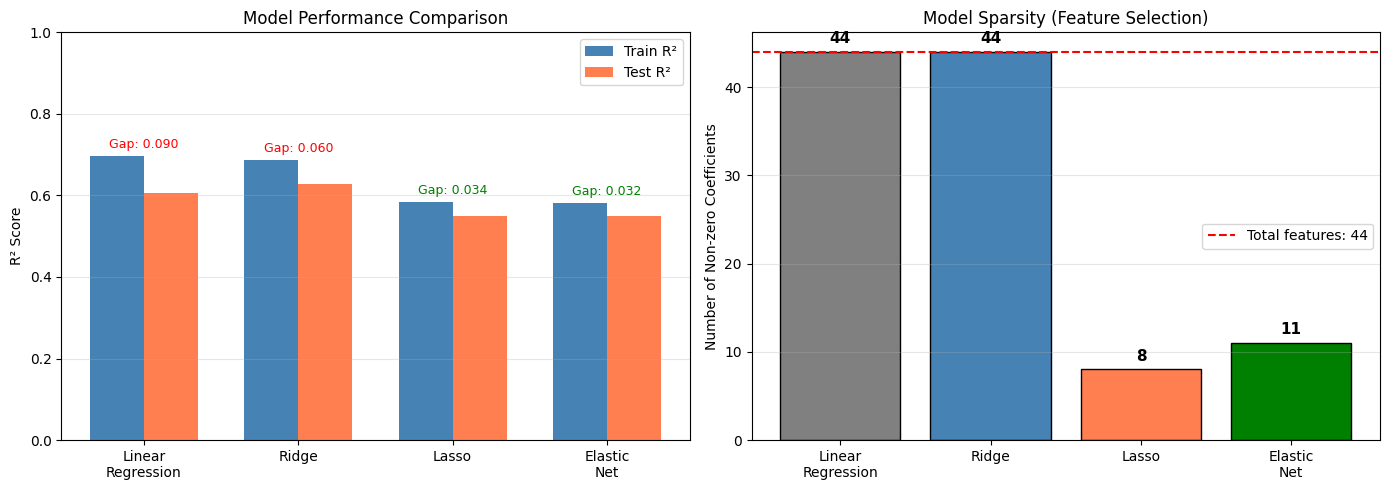

In [ ]:
# Visualize final comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: R² Comparison
x = np.arange(len(results))
width = 0.35

bars1 = axes[0].bar(x - width/2, results_df['Train R²'], width, label='Train R²', color='steelblue')
bars2 = axes[0].bar(x + width/2, results_df['Test R²'], width, label='Test R²', color='coral')

axes[0].set_ylabel('R² Score')
axes[0].set_title('Model Performance Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['Linear\nRegression', 'Ridge', 'Lasso', 'Elastic\nNet'], fontsize=10)
axes[0].legend()
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', alpha=0.3)

# Add overfitting gap annotations
for i, (train, test) in enumerate(zip(results_df['Train R²'], results_df['Test R²'])):
    gap = train - test
    color = 'red' if gap > 0.05 else 'green'
    axes[0].annotate(f'Gap: {gap:.3f}', xy=(i, max(train, test) + 0.02),
                     ha='center', fontsize=9, color=color)

# Plot 2: Sparsity Comparison
colors = ['gray', 'steelblue', 'coral', 'green']
bars = axes[1].bar(x, results_df['Non-zero Coefs'], color=colors, edgecolor='black')
axes[1].set_ylabel('Number of Non-zero Coefficients')
axes[1].set_title('Model Sparsity (Feature Selection)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(['Linear\nRegression', 'Ridge', 'Lasso', 'Elastic\nNet'], fontsize=10)
axes[1].axhline(y=X_train_scaled.shape[1], color='red', linestyle='--', label=f'Total features: {X_train_scaled.shape[1]}')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Add count labels
for bar, count in zip(bars, results_df['Non-zero Coefs']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                 str(count), ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

---
# Section 9: How to Choose Lambda (α)

## Cross-Validation for Hyperparameter Selection

λ (alpha) is a **hyperparameter**—it's not learned from data, it must be chosen:

- **Too small**: Overfitting (like no regularization)
- **Too large**: Underfitting (all coefficients near zero)

**Solution:** Use cross-validation to find the optimal λ. Scikit-learn provides `RidgeCV`, `LassoCV`, and `ElasticNetCV` for this purpose.

In [ ]:
# Demonstrate cross-validation for alpha selection
alphas = np.logspace(-4, 2, 50)

# Manual cross-validation for Ridge to show the process
cv_scores = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    scores = cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='r2')
    cv_scores.append({
        'alpha': alpha,
        'mean_score': scores.mean(),
        'std_score': scores.std()
    })

cv_df = pd.DataFrame(cv_scores)

# Find best alpha
best_idx = cv_df['mean_score'].idxmax()
best_alpha = cv_df.loc[best_idx, 'alpha']
best_score = cv_df.loc[best_idx, 'mean_score']

print(f"Best alpha from cross-validation: {best_alpha:.4f}")
print(f"Best CV R² score: {best_score:.4f}")

Best alpha from cross-validation: 0.0869
Best CV R² score: 0.5644


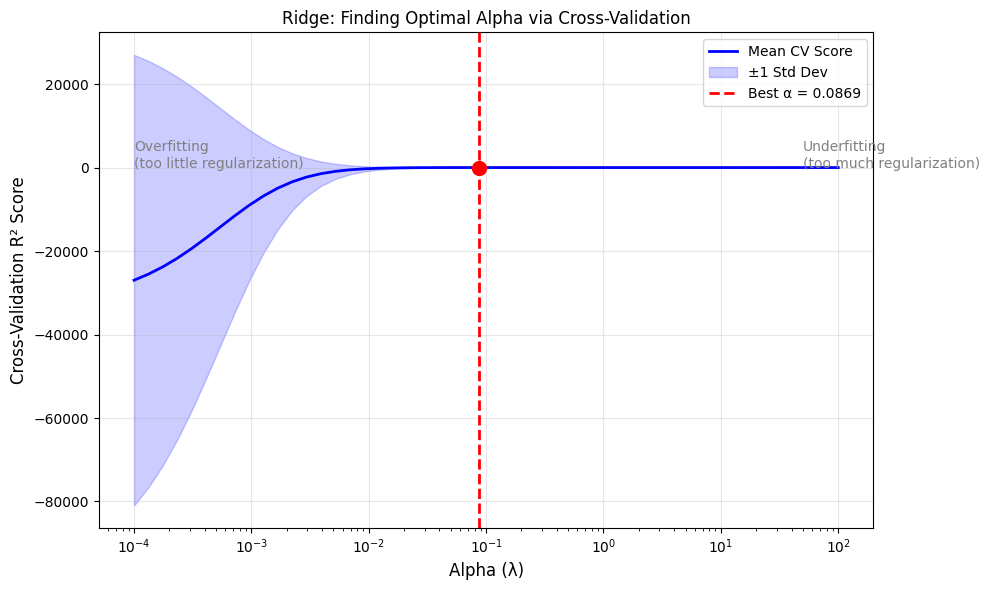

In [ ]:
# Visualize cross-validation results
fig, ax = plt.subplots(figsize=(10, 6))

ax.semilogx(cv_df['alpha'], cv_df['mean_score'], 'b-', linewidth=2, label='Mean CV Score')
ax.fill_between(cv_df['alpha'],
                cv_df['mean_score'] - cv_df['std_score'],
                cv_df['mean_score'] + cv_df['std_score'],
                alpha=0.2, color='blue', label='±1 Std Dev')

ax.axvline(x=best_alpha, color='red', linestyle='--', linewidth=2, label=f'Best α = {best_alpha:.4f}')
ax.scatter([best_alpha], [best_score], color='red', s=100, zorder=5)

ax.set_xlabel('Alpha (λ)', fontsize=12)
ax.set_ylabel('Cross-Validation R² Score', fontsize=12)
ax.set_title('Ridge: Finding Optimal Alpha via Cross-Validation', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

# Add annotations for underfitting/overfitting regions
ax.annotate('Underfitting\n(too much regularization)', xy=(50, 0.4), fontsize=10, color='gray')
ax.annotate('Overfitting\n(too little regularization)', xy=(0.0001, 0.4), fontsize=10, color='gray')

plt.tight_layout()
plt.show()

---
# Section 10: Always Scale Features Before Regularization!

## Why Scaling Matters

Regularization penalizes coefficient size. Since feature scale directly affects coefficient magnitude, **without scaling, large-scale features dominate and distort model training**.

**Rule:** Always standardize or normalize features before Ridge, Lasso, or Elastic Net!

In [ ]:
# Demonstrate the importance of scaling
print("Feature Ranges BEFORE Scaling:")
print(X_train.describe().loc[['min', 'max']].T)

print("\n" + "="*50)
print("\nNotice: Features have VERY different scales!")
print("- MedInc: ~0.5 to ~15")
print("- Population: ~3 to ~35,000+")
print("- AveRooms: ~0.8 to ~141")

Feature Ranges BEFORE Scaling:
                   min           max
MedInc        0.499900     15.000100
HouseAge      2.000000     52.000000
AveRooms      1.130435     47.515152
AveBedrms     0.555556     11.181818
Population    3.000000  35682.000000
AveOccup      0.692308    502.461538
Latitude     32.560000     41.950000
Longitude  -124.230000   -114.550000


Notice: Features have VERY different scales!
- MedInc: ~0.5 to ~15
- Population: ~3 to ~35,000+
- AveRooms: ~0.8 to ~141


In [ ]:
# Compare Ridge with and without scaling
print("Ridge Regression: Scaled vs Unscaled Features")
print("=" * 60)

# Without scaling
ridge_unscaled = Ridge(alpha=1.0)
ridge_unscaled.fit(X_train_poly, y_train)  # Unscaled polynomial features
unscaled_test_r2 = ridge_unscaled.score(X_test_poly, y_test)

# With scaling
ridge_scaled = Ridge(alpha=1.0)
ridge_scaled.fit(X_train_scaled, y_train)  # Scaled polynomial features
scaled_test_r2 = ridge_scaled.score(X_test_scaled, y_test)

print(f"Without scaling: Test R² = {unscaled_test_r2:.4f}")
print(f"With scaling:    Test R² = {scaled_test_r2:.4f}")
print(f"\nImprovement from scaling: {scaled_test_r2 - unscaled_test_r2:.4f}")

Ridge Regression: Scaled vs Unscaled Features
Without scaling: Test R² = 0.5615
With scaling:    Test R² = 0.6325

Improvement from scaling: 0.0710


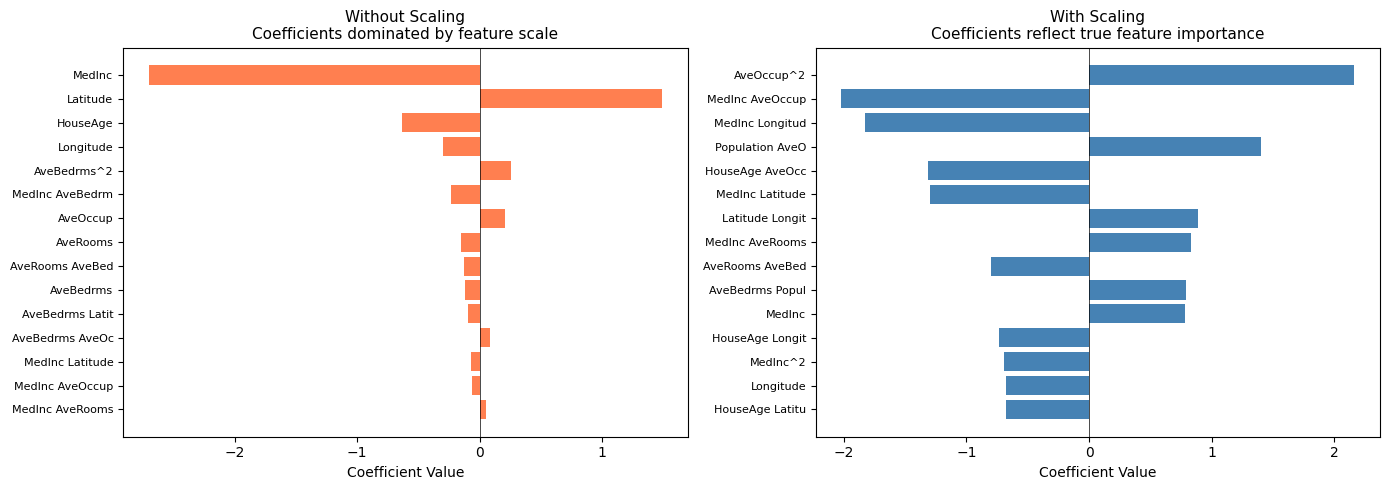

In [ ]:
# Visualize coefficient magnitudes with and without scaling
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Unscaled coefficients
sorted_idx = np.argsort(np.abs(ridge_unscaled.coef_))[::-1][:15]
axes[0].barh(range(len(sorted_idx)), ridge_unscaled.coef_[sorted_idx], color='coral')
axes[0].set_yticks(range(len(sorted_idx)))
axes[0].set_yticklabels([feature_names[i][:15] for i in sorted_idx], fontsize=8)
axes[0].set_xlabel('Coefficient Value')
axes[0].set_title('Without Scaling\nCoefficients dominated by feature scale', fontsize=11)
axes[0].axvline(x=0, color='black', linewidth=0.5)
axes[0].invert_yaxis()

# Scaled coefficients
sorted_idx = np.argsort(np.abs(ridge_scaled.coef_))[::-1][:15]
axes[1].barh(range(len(sorted_idx)), ridge_scaled.coef_[sorted_idx], color='steelblue')
axes[1].set_yticks(range(len(sorted_idx)))
axes[1].set_yticklabels([feature_names[i][:15] for i in sorted_idx], fontsize=8)
axes[1].set_xlabel('Coefficient Value')
axes[1].set_title('With Scaling\nCoefficients reflect true feature importance', fontsize=11)
axes[1].axvline(x=0, color='black', linewidth=0.5)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

---
# Section 11: Benefits of Regularization - Summary

## When to Use Regularization

Regularization is especially valuable when:

1. **Many features, few samples** (p > n or p ≈ n): Classic high-dimensional problem
2. **Highly correlated features**: Regularization stabilizes coefficient estimates
3. **Feature engineering created many terms**: Polynomials and interactions (like we did!)
4. **Model interpretability matters**: Lasso for automatic feature selection

### Quick Reference

| Situation | Best Choice |
|-----------|-------------|
| All features potentially relevant | Ridge |
| Want sparse model / feature selection | Lasso |
| Correlated feature groups | Elastic Net |
| Unsure which to use | Start with Elastic Net (l1_ratio=0.5) |

---
# Exercises

## EXERCISE 1: Ridge Regression

1. Create a Ridge regression model with α = 10
2. Fit it on the scaled polynomial features (`X_train_scaled`, `y_train`)
3. Calculate the training and test R² scores
4. Count how many coefficients have absolute value > 0.1

In [ ]:
# 1. Create a Ridge regression model with α = 10

# Write your code here


In [ ]:
#@title Click to reveal solution.

# 1. Create a Ridge regression model with α = 10
ridge_ex = Ridge(alpha=10)
ridge_ex

Ridge(alpha=10)

In [ ]:
# 2. Fit it on the scaled polynomial features

# Write your code here


In [ ]:
#@title Click to reveal solution.

# 2. Fit it on the scaled polynomial features
ridge_ex.fit(X_train_scaled, y_train)

Ridge(alpha=10)

In [ ]:
# 3. Calculate the training and test R² scores

# Write your code here


In [ ]:
#@title Click to reveal solution.

# 3. Calculate the training and test R² scores
train_r2 = ridge_ex.score(X_train_scaled, y_train)
test_r2 = ridge_ex.score(X_test_scaled, y_test)

print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

Training R²: 0.6671
Test R²: 0.2970


In [ ]:
# 4. Count how many coefficients have absolute value > 0.1

# Write your code here


In [ ]:
#@title Click to reveal solution.

# 4. Count how many coefficients have absolute value > 0.1
n_large_coefs = np.sum(np.abs(ridge_ex.coef_) > 0.1)
print(f"Coefficients with |β| > 0.1: {n_large_coefs} out of {len(ridge_ex.coef_)}")

Coefficients with |β| > 0.1: 34 out of 44


## EXERCISE 2: Lasso Feature Selection

1. Create a Lasso model with α = 0.05
2. Fit it and identify how many features have exactly zero coefficients
3. Print the names of the top 5 most important features (largest absolute coefficients)

In [ ]:
# 1. Create a Lasso model with α = 0.05

# Write your code here


In [ ]:
#@title Click to reveal solution.

# 1. Create a Lasso model with α = 0.05
lasso_ex = Lasso(alpha=0.05, max_iter=10000)
lasso_ex.fit(X_train_scaled, y_train)

Lasso(alpha=0.05, max_iter=10000)

In [ ]:
# 2. Count features with exactly zero coefficients

# Write your code here


In [ ]:
#@title Click to reveal solution.

# 2. Count features with exactly zero coefficients
n_zero = np.sum(lasso_ex.coef_ == 0)
n_nonzero = np.sum(lasso_ex.coef_ != 0)

print(f"Features with zero coefficient: {n_zero}")
print(f"Features kept (non-zero): {n_nonzero}")
print(f"\nLasso eliminated {n_zero/len(lasso_ex.coef_)*100:.1f}% of features!")

Features with zero coefficient: 38
Features kept (non-zero): 6

Lasso eliminated 86.4% of features!


In [ ]:
# 3. Print the names of the top 5 most important features

# Write your code here


In [ ]:
#@title Click to reveal solution.

# 3. Print the names of the top 5 most important features
# Get indices sorted by absolute coefficient value
top_5_idx = np.argsort(np.abs(lasso_ex.coef_))[::-1][:5]

print("Top 5 Most Important Features (Lasso):")
print("-" * 40)
for i, idx in enumerate(top_5_idx, 1):
    print(f"{i}. {feature_names[idx]}: {lasso_ex.coef_[idx]:.4f}")

Top 5 Most Important Features (Lasso):
----------------------------------------
1. MedInc Longitude: -0.6334
2. Latitude^2: -0.2977
3. Longitude: -0.2257
4. MedInc HouseAge: 0.1397
5. HouseAge^2: 0.0445


## EXERCISE 3: Cross-Validation for Lasso

1. Use `LassoCV` to find the optimal alpha value
2. Report the best alpha and the corresponding test R² score
3. How many features does this optimal model keep?

In [ ]:
# 1. Use LassoCV to find the optimal alpha

# Write your code here


In [ ]:
#@title Click to reveal solution.

# 1. Use LassoCV to find the optimal alpha
lasso_cv_ex = LassoCV(alphas=np.logspace(-4, 0, 100), cv=5, max_iter=10000)
lasso_cv_ex.fit(X_train_scaled, y_train)

print(f"Best alpha found: {lasso_cv_ex.alpha_:.6f}")

Best alpha found: 0.024201


In [ ]:
# 2. Report test R² score

# Write your code here


In [ ]:
#@title Click to reveal solution.

# 2. Report test R² score
test_r2_cv = lasso_cv_ex.score(X_test_scaled, y_test)
print(f"Test R² with optimal alpha: {test_r2_cv:.4f}")

Test R² with optimal alpha: 0.5507


In [ ]:
# 3. How many features does the optimal model keep?

# Write your code here


In [ ]:
#@title Click to reveal solution.

# 3. How many features does the optimal model keep?
n_nonzero_cv = np.sum(lasso_cv_ex.coef_ != 0)
print(f"Features kept by optimal Lasso: {n_nonzero_cv} out of {len(lasso_cv_ex.coef_)}")

Features kept by optimal Lasso: 8 out of 44


## EXERCISE 4: Compare All Methods

Create a visualization comparing:
1. Linear Regression (no regularization)
2. Ridge with α = 1
3. Lasso with α = 0.01
4. Elastic Net with α = 0.01 and l1_ratio = 0.5

Show both the test R² score and the number of non-zero coefficients for each.

In [ ]:
# Create and fit all four models, then create a comparison visualization

# Write your code here


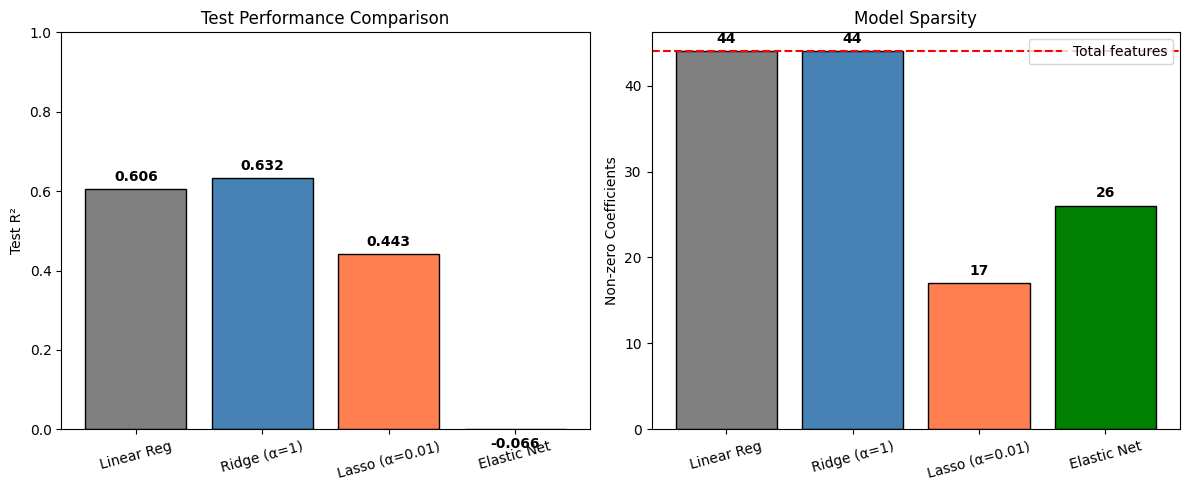

         Model   Test R²  Non-zero Coefs
    Linear Reg  0.606075              44
   Ridge (α=1)  0.632480              44
Lasso (α=0.01)  0.442512              17
   Elastic Net -0.065995              26


In [ ]:
#@title Click to reveal solution.

# Create and fit all four models
models_ex = {
    'Linear Reg': LinearRegression(),
    'Ridge (α=1)': Ridge(alpha=1),
    'Lasso (α=0.01)': Lasso(alpha=0.01, max_iter=10000),
    'Elastic Net': ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000)
}

results_ex = []
for name, model in models_ex.items():
    model.fit(X_train_scaled, y_train)
    test_r2 = model.score(X_test_scaled, y_test)
    n_nonzero = np.sum(model.coef_ != 0)
    results_ex.append({'Model': name, 'Test R²': test_r2, 'Non-zero Coefs': n_nonzero})

results_ex_df = pd.DataFrame(results_ex)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Test R² comparison
colors = ['gray', 'steelblue', 'coral', 'green']
axes[0].bar(results_ex_df['Model'], results_ex_df['Test R²'], color=colors, edgecolor='black')
axes[0].set_ylabel('Test R²')
axes[0].set_title('Test Performance Comparison')
axes[0].set_ylim(0, 1)
axes[0].tick_params(axis='x', rotation=15)
for i, v in enumerate(results_ex_df['Test R²']):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Sparsity comparison
axes[1].bar(results_ex_df['Model'], results_ex_df['Non-zero Coefs'], color=colors, edgecolor='black')
axes[1].set_ylabel('Non-zero Coefficients')
axes[1].set_title('Model Sparsity')
axes[1].axhline(y=44, color='red', linestyle='--', label='Total features')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=15)
for i, v in enumerate(results_ex_df['Non-zero Coefs']):
    axes[1].text(i, v + 1, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(results_ex_df.to_string(index=False))

---
# Summary

In this notebook, you learned:

1. **The Overfitting Problem**: Complex models can memorize training data but fail to generalize

2. **Bias-Variance Tradeoff**: Finding the sweet spot between underfitting and overfitting

3. **Ridge Regression (L2)**: Shrinks coefficients but keeps all features; good for multicollinearity

4. **Lasso Regression (L1)**: Can set coefficients exactly to zero; automatic feature selection

5. **Elastic Net**: Combines L1 and L2; best of both worlds for correlated features

6. **Choosing Lambda**: Use cross-validation to find the optimal regularization strength

7. **Always Scale Features**: Regularization is scale-dependent; standardize before fitting

**Key Takeaway**: Regularization is your tool for controlling model complexity and improving generalization, especially when you have many features!